# Community Water System Prediction Model

The [Division of Drinking Water](https://www.waterboards.ca.gov/drinking_water/programs/) (DDW) at the [California State Water Resources Control Board](https://www.waterboards.ca.gov/) regulates 2800 Community Water Systems (CWS) throughout the state. Some of these CWS risk running out of water during the dry summer season. This code creates a machine learning model that predicts which CWS face the highest risk of running out of water. The model is intended to run in production on a monthly basis, producing predictions for at-risk CWS within the subsequent ninety days. 

In [1]:
import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
from datetime import datetime as dt_obj

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 1000)

### Read in the initial dataset

The initial data set provided by the DDW include two csv files that contain data from 2020 and 2021: `DroughtWatchPrioritization_v4.csv` and 
`DroughtWatchPrioritization_v9_input_data_with_TNC.csv`.  The files provide a list of CWS, various parameters that describe the CWS, and the outcome of each CWS at the end of 2021 via the label `DroughtExperienced`. If `DroughtExperienced` equals 1, a CWS ran out of water; otherwise, the system was safe.

In [2]:
BUCKET_NAME = 'aae-water-dev-us-west-2'

In [3]:
s3 = boto3.resource('s3')
s3_client = boto3.client('s3')
water_bucket = s3.Bucket(BUCKET_NAME)

In [4]:
files = []
for water_bucket_object in water_bucket.objects.all():
    files.append(water_bucket_object.key)

In [5]:
dfs = []
for file in files:
    response = s3_client.get_object(Bucket=BUCKET_NAME, Key=file)
    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
    print(status, file)
    if status == 200:
        dfs.append(pd.read_csv(response.get("Body")))

200 202304_TNC monthly-flow estimation.csv
200 DroughtWatchPrioritization_v4.csv
200 DroughtWatchPrioritization_v9_input_data_with_TNC.csv
200 HUC_Code_Name_Crosswalk.csv
200 dsci_export_20180501_20230524.csv
200 monthly_net_purchaser_output.csv
200 seasonal_gw_measurements_output.csv
200 seasonal_net_purchaser_output.csv


In [6]:
df1 = dfs[1]
df2 = dfs[2]

The keyword `PWPhysicalAddressLat` in one dataframe is the same as `Lat` in other other; same with longitude. Rename these keywords.

In [7]:
df2 = df2.rename(columns={"Lat": "PWPhysicalAddressLat", "Long": "PWPhysicalAddressLong"})

Why are there multiple CWS at the same location? Is this correct? (See table below)

In [8]:
df2[['ServiceConnections', 'Population', 'CDAG_rank', 'PWPhysicalAddressLat', 'PWPhysicalAddressLong']][30:39]

,ServiceConnections,Population,CDAG_rank,PWPhysicalAddressLat,PWPhysicalAddressLong
30,1742,4943,-1,38.382864,-120.787745
31,520,1060,2322,38.480957,-120.847427
32,388,907,1805,38.413058,-120.658861
33,215,510,1757,38.544707,-120.741079
34,211,1184,1445,38.191586,-120.829103
35,337,838,1636,38.458547,-120.541518
36,2743,8809,-1,38.382864,-120.787745
37,82,200,1713,38.447565,-120.537917
38,55,188,-1,38.382864,-120.787745


What does a CDAG_rank of -1 mean? Is this the same as NaN? There are 666 CWS with a CDAG_rank of -1. (Showing only ten here).

In [9]:
df1[['ServiceConnections', 'Population', 'CWSID', 'CDAG_rank', 'PWPhysicalAddressLat', 'PWPhysicalAddressLong']].loc[df1['CDAG_rank'] == -1][10:20] 

,ServiceConnections,Population,CWSID,CDAG_rank,PWPhysicalAddressLat,PWPhysicalAddressLong
29,2106,6170,CA0310002,-1,38.382864,-120.787745
30,1742,4943,CA0310003,-1,38.382864,-120.787745
36,2743,8809,CA0310012,-1,38.382864,-120.787745
38,55,188,CA0310019,-1,38.382864,-120.787745
73,29610,104908,CA0410002,-1,39.719981,-121.808483
76,3551,10698,CA0410005,-1,39.511060,-121.554885
77,6909,22780,CA0410006,-1,39.510752,-121.519610
78,2369,4600,CA0410007,-1,39.768527,-121.599204
79,3077,10154,CA0410008,-1,39.532157,-121.574237
81,3198,10513,CA0410011,-1,39.819135,-121.590983


Merge the two dataframes using these keys: `ServiceConnections`, `Population`, `CDAG_rank`, and `Lat`. The ideal solution is to merge on the unique identifier, `CWSID`. However, `CWSID` is not present in both files.

In [10]:
df_initial = df1.merge(df2, on=['ServiceConnections', 'Population', 'CDAG_rank', 'PWPhysicalAddressLat'])

Remove the '-' character from the HUC8 values to make them consistent with other datasets.

In [11]:
df_initial['HUC8'] = df_initial['HUC8'].str.replace("-", "").astype(int)

### Add [California Natural Flows Data](https://rivers.codefornature.org)

The California Natural Flows Database (NFD) contains predicted natural stream flows for every stream in California at a monthly cadence from 1950 to 2022. The Nature Conservancy and the USGS used a three different random forest algorithms to model the flow rate in three different regions:
* Interior Mountains (including the Sierra Nevada and Klamath mountains)
* North Coastal Mountains (including the mountains in the north western portion of the state)
* Xeric (including the Central Valley, Central and South Coast, and desert portions of the state)

The process is described in [Zimmerman et al. 2017](https://doi.org/10.1111/fwb.13058). They acknowledge inflated values during the dry season, saying: "While the frequency of monthly flow alteration tended to be low, the degree of alteration was substantial. ... Inflation of monthly flows was most pronounced in the dry summer months, when flows in California streams are typically at their lowest level."

It may be useful to use actual measurements, rather than predicted values -- e.g. data from the [California Nevada River Forecast Center](https://www.cnrfc.noaa.gov/).


**Step 1: Obtain a complete list of HUC8 codes in California.** The California Department of Water Resources put a [simplifed mapping HUC8 codes](https://data.ca.gov/dataset/huc8-ca-simplified) within the state of California on the California Open Data Portal. Since HUC8 codes follow watershed boundaries, some span multiple states. This simplified mapping is clipped to the political boundary using ArcGIS.

**Step 2: Obtain flow data per HUC8 code per unit time.** The data are provided in a field called `value`.  

Complete Step 1:

In [12]:
url_huc8 = 'https://gis.data.cnra.ca.gov/datasets/02ff4971b8084ca593309036fb72289c_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D'

In [13]:
df_huc8 = pd.read_csv(url_huc8)

Complete Step 2:

In [14]:
df0 = dfs[0]

In [15]:
df0['Date'] = df0[['year', 'month']].astype(str).agg('-'.join, axis=1) 

In [16]:
df0 = df0.drop(columns=['comid', 'statistic', 'variable', 'month', 'year', 'pct_rank',
       'GNIS_NAME', 'FTYPE', 'FCODE', 'stream_ord', 'name', 'method'])

In [17]:
# Convert the keyword MapDate into a datetime object
df0['Date'] = pd.to_datetime(df0['Date'], format = '%Y-%m').reset_index(drop=True)

In [18]:
df0['huc8'].dtype

dtype('int64')

In [21]:
# Define the dry season 2021
start_dry_season = dt_obj.fromisoformat('2021-05-01')
end_dry_season = dt_obj.fromisoformat('2021-09-30')

# Define the wet season 2021
start_wet_season = dt_obj.fromisoformat('2021-10-01')
end_wet_season = dt_obj.fromisoformat('2022-04-01')

In [22]:
all_huc_ids = []
all_average_flows_dry_season = []
all_max_flows_dry_season = []
all_standard_deviation_flows_dry_season = []
all_delta_flows = []
for i in range(len(df_huc8['HUC8'])):  
    # Get an individual HUC8 region in California
    one_huc8_code = df_huc8['HUC8'][i]
    print('Calculating features for HUC8 region',one_huc8_code, df_huc8['Name'][i])
    df_one_huc = df0[df0['huc8'] == one_huc8_code]

    # Identify the dry season
    mask_dry = (df_one_huc['Date'] > start_dry_season) & (df_one_huc['Date'] <= end_dry_season)
    df_dry = df_one_huc[mask_dry]
    
    # Calculate the maximum, average, and standard deviation of the flow during the dry season
    max_flow_dry_season = np.nanmax(df_dry['value'])
    average_flow_dry_season = np.nanmean(df_dry['value'])
    standard_deviation_dry_season_flow = np.nanstd(df_dry['value'])
    
    # Identify the wet season
    mask_wet = (df_one_huc['Date'] > start_wet_season) & (df_one_huc['Date'] <= end_wet_season)
    df_wet = df_one_huc[mask_wet]
    
    # Calculate the average flow during the wet season
    average_flow_wet_season = np.nanmean(df_wet['value'])
    
    # Calculate the change in average flow between dry and wet seasons
    delta_flow = average_flow_dry_season - average_flow_wet_season
    
    # Save the data to a list
    all_huc_ids.append(one_huc8_code)
    all_max_flows_dry_season.append(max_flow_dry_season)
    all_average_flows_dry_season.append(average_flow_dry_season)
    all_standard_deviation_flows_dry_season.append(standard_deviation_dry_season_flow)
    all_delta_flows.append(delta_flow)

Calculating features for HUC8 region 18100204 Salton Sea
Calculating features for HUC8 region 18070303 San Luis Rey-Escondido
Calculating features for HUC8 region 18070304 San Diego
Calculating features for HUC8 region 18020162 Upper Putah
Calculating features for HUC8 region 18050001 Suisun Bay
Calculating features for HUC8 region 15030102 Piute Wash
Calculating features for HUC8 region 18100100 Southern Mojave
Calculating features for HUC8 region 18030003 Middle Kern-Upper Tehachapi-Grapevine
Calculating features for HUC8 region 18060003 Carrizo Plain
Calculating features for HUC8 region 18060007 Cuyama
Calculating features for HUC8 region 18070102 Santa Clara
Calculating features for HUC8 region 18090206 Antelope-Fremont Valleys
Calculating features for HUC8 region 18020002 Upper Pit
Calculating features for HUC8 region 18080002 Madeline Plains
Calculating features for HUC8 region 17100309 Applegate
Calculating features for HUC8 region 17100311 Illinois
Calculating features for HUC8

In [23]:
df_flow_data = pd.DataFrame({'HUC8': all_huc_ids, 
                   'Flow Dry Season Max': all_max_flows_dry_season,        
                   'Flow Dry Season Average': all_average_flows_dry_season,
                   'Flow Dry Season Standard Deviation': all_standard_deviation_flows_dry_season,
                   'Flow Dry Wet Delta': all_delta_flows})

In [24]:
df_initial_plus_flow = df_initial.merge(df_flow_data, on='HUC8', how='left')

### Add [US Drought Monitor Data](https://droughtmonitor.unl.edu/)

**Step 1: Obtain a complete list of HUC8 codes in California.** The California Department of Water Resources put a [simplifed mapping HUC8 codes](https://data.ca.gov/dataset/huc8-ca-simplified) within the state of California on the California Open Data Portal. Since HUC8 codes follow watershed boundaries, some span multiple states. This simplified mapping is clipped to the political boundary using ArcGIS.

**Step 2: Obtain DSCI data per HUC8 code per unit time.** 
* The [US Drought Monitor Index](https://droughtmonitor.unl.edu/) provides several drought-related datasets. These data are available through a REST API. 
* Construct the URL for the REST API. The query terms are: 
  * `[area]` = `HUCStatistics`
  * `[statistics type]` = `GetDroughtSeverityStatisticsByAreaPercent` (Note: One could use `GetDSCI`, but this will not return HUC8 codes as a key)
  * `[aoi]` = Any given HUC8 code, e.g. 15040004
  * `[start date]` = 01/01/2021
  * `[end date]` = 01/01/2022
  * `[statistics type]` = 2. (Note: This is a different keyword from the first statistics type. A statistics type of 2 refers to categorical statistics).
* Here is an example URL: url_dsci = `https://usdmdataservices.unl.edu/api/HUCStatistics/GetDroughtSeverityStatisticsByAreaPercent?aoi=15040004&startdate=1/2/2021&enddate=12/27/2021&statisticsType=2`

**Step 3: Calculate the Drought Severity and Coverage Index (DSCI).** Compute a weighted sum of the categorical percent area as described [here](https://droughtmonitor.unl.edu/About/AbouttheData/DSCI.aspx): DSCI = 1(D0) + 2(D1) + 3(D2) + 4(D3) + 5(D4)

Step 1, add additional seasons:

In [25]:
# Define the dry seasons
dry_seasons_start = [dt_obj.fromisoformat('2021-05-01'), dt_obj.fromisoformat('2020-05-01'), dt_obj.fromisoformat('2019-05-01')]
dry_seasons_end = [dt_obj.fromisoformat('2021-09-30'), dt_obj.fromisoformat('2020-09-30'), dt_obj.fromisoformat('2019-09-30')]

# Define the wet seasons
wet_seasons_start = [dt_obj.fromisoformat('2021-10-01'), dt_obj.fromisoformat('2020-10-01'), dt_obj.fromisoformat('2019-10-01')]
wet_seasons_end = [dt_obj.fromisoformat('2022-04-01'), dt_obj.fromisoformat('2021-04-01'), dt_obj.fromisoformat('2020-04-01')]

Complete Steps 2 and 3:

In [26]:
all_huc_ids = []
all_average_dscis_dry_season = []
all_max_dscis_dry_season = []
all_standard_deviation_dscis_dry_season = []
all_delta_dscis = []
years_average_dscis_dry_season = []
years_max_dscis_dry_season = []
years_standard_deviation_dscis_dry_season = []
years_delta_dscis = []
for i in range(len(df_huc8['HUC8'])):
    # Get an individual HUC8 region in California
    one_huc8_code = df_huc8['HUC8'][i]
    print('Fetching data for HUC8 region',one_huc8_code, df_huc8['Name'][i])
    url_dsci = 'https://usdmdataservices.unl.edu/api/HUCStatistics/GetDroughtSeverityStatisticsByAreaPercent?aoi='+str(one_huc8_code)+'&startdate=1/1/2019&enddate=12/31/2021&statisticsType=2'
    df_one_huc = pd.read_json(url_dsci)
    
    # Convert the keyword MapDate into a datetime object
    df_one_huc['MapDate'] = pd.to_datetime(df_one_huc['MapDate'], format = '%Y%m%d').reset_index(drop=True)
    
    # Save the data to a list
    all_huc_ids.append(one_huc8_code)

    for j in range(len(dry_seasons_start)):
        # Identify one dry season
        mask_dry = (df_one_huc['MapDate'] > dry_seasons_start[j]) & (df_one_huc['MapDate'] <= dry_seasons_end[j])
        df_dry = df_one_huc[mask_dry]

        # Calculate the maximum, average, and standard deviation of the DSCI during the dry season
        max_dsci_dry_season = np.nanmax(1*df_dry.D0 + 2*df_dry.D1 + 3*df_dry.D2 + 4*df_dry.D3 + 5*df_dry.D4)
        average_dsci_dry_season = np.nanmean(1*df_dry.D0 + 2*df_dry.D1 + 3*df_dry.D2 + 4*df_dry.D3 + 5*df_dry.D4)
        standard_deviation_dry_season_dsci = np.nanstd(1*df_dry.D0 + 2*df_dry.D1 + 3*df_dry.D2 + 4*df_dry.D3 + 5*df_dry.D4)

        # Identify one wet season
        mask_wet = (df_one_huc['MapDate'] > wet_seasons_start[j]) & (df_one_huc['MapDate'] <= wet_seasons_end[j])
        df_wet = df_one_huc[mask_wet]

        # Calculate the average DSCI during the wet season
        average_dsci_wet_season = np.nanmean(1*df_wet.D0 + 2*df_wet.D1 + 3*df_wet.D2 + 4*df_wet.D3 + 5*df_wet.D4)

        # Calculate the change in average DSCI between dry and wet seasons
        delta_dsci = average_dsci_dry_season - average_dsci_wet_season
    
        # Concatenate each feature by years
        years_max_dscis_dry_season.append(max_dsci_dry_season)
        years_average_dscis_dry_season.append(average_dsci_dry_season)
        years_standard_deviation_dscis_dry_season.append(standard_deviation_dry_season_dsci)
        years_delta_dscis.append(delta_dsci)
    
    # Save the data to a list
    all_max_dscis_dry_season.append(years_max_dscis_dry_season)
    all_average_dscis_dry_season.append(years_average_dscis_dry_season)
    all_standard_deviation_dscis_dry_season.append(years_standard_deviation_dscis_dry_season)
    all_delta_dscis.append(years_delta_dscis)
    
    years_average_dscis_dry_season = []
    years_max_dscis_dry_season = []
    years_standard_deviation_dscis_dry_season = []
    years_delta_dscis = []

Fetching data for HUC8 region 18100204 Salton Sea
Fetching data for HUC8 region 18070303 San Luis Rey-Escondido
Fetching data for HUC8 region 18070304 San Diego
Fetching data for HUC8 region 18020162 Upper Putah
Fetching data for HUC8 region 18050001 Suisun Bay
Fetching data for HUC8 region 15030102 Piute Wash
Fetching data for HUC8 region 18100100 Southern Mojave
Fetching data for HUC8 region 18030003 Middle Kern-Upper Tehachapi-Grapevine
Fetching data for HUC8 region 18060003 Carrizo Plain
Fetching data for HUC8 region 18060007 Cuyama
Fetching data for HUC8 region 18070102 Santa Clara
Fetching data for HUC8 region 18090206 Antelope-Fremont Valleys
Fetching data for HUC8 region 18020002 Upper Pit
Fetching data for HUC8 region 18080002 Madeline Plains
Fetching data for HUC8 region 17100309 Applegate
Fetching data for HUC8 region 17100311 Illinois
Fetching data for HUC8 region 18030009 Upper Dry
Fetching data for HUC8 region 18040001 Middle San Joaquin-Lower Chowchilla
Fetching data for

In [27]:
df_drought_data = pd.DataFrame({
                   'HUC8': all_huc_ids, 
                   'DSCI 2021 Dry Season Max': [item[0] for item in all_max_dscis_dry_season],        
                   'DSCI 2021 Dry Season Average': [item[0] for item in all_average_dscis_dry_season],
                   'DSCI 2021 Dry Season Standard Deviation': [item[0] for item in all_standard_deviation_dscis_dry_season],
                   'DSCI 2021 Dry Wet Delta': [item[0] for item in all_delta_dscis],
                   'DSCI 2020 Dry Season Max': [item[1] for item in all_max_dscis_dry_season],        
                   'DSCI 2020 Dry Season Average': [item[1] for item in all_average_dscis_dry_season],
                   'DSCI 2020 Dry Season Standard Deviation': [item[1] for item in all_standard_deviation_dscis_dry_season],
                   'DSCI 2020 Dry Wet Delta': [item[1] for item in all_delta_dscis],  
                   'DSCI 2019 Dry Season Max': [item[2] for item in all_max_dscis_dry_season],        
                   'DSCI 2019 Dry Season Average': [item[2] for item in all_average_dscis_dry_season],
                   'DSCI 2019 Dry Season Standard Deviation': [item[2] for item in all_standard_deviation_dscis_dry_season],
                   'DSCI 2019 Dry Wet Delta': [item[2] for item in all_delta_dscis],
})

In [28]:
df = df_initial_plus_flow.merge(df_drought_data, on='HUC8', how='left')

In [29]:
df.columns

Index(['CWSID', 'RegulatingAgency', 'WaterSystemName',
       'Score_DroughtWatchStatus', 'WaterOutageDroughtViolation',
       'BottledHauledWaterOrZeroSource', 'CurtailmentExemptionPetition',
       'Score_1704', 'FundedProject', 'DroughtExperienced_x',
       'ServiceConnections', 'Population', 'Score_SourceNumber_x', 'Score_SCV',
       'Score_SCM_x', 'Score_CriticallyOverdraftedGroundwaterBasin_x',
       'CDAG_rank', 'Curtailment_x', 'Score_1702_x', 'Score_1705_x',
       'Score_1706_x', 'Score_1812_x', 'Score_1813_x', 'Score_1814_x',
       'Score_1815_x', 'EAR2020DroughtRiskScore_x',
       'SAFER_AccessibilityScore_x', 'PWPhysicalAddressLat',
       'PWPhysicalAddressLong_x', 'CentralValleyCounties',
       'NonCentralValleyCounties', 'ActiveGWSource_x', 'ActiveSWSource_x',
       'CurtailedWatershed_x', 'HUC4_x', 'HUC8_CentralValley', 'HUC8_Coast',
       'HUC8_Other', 'Basin_Number_part1_x', 'FracturedRock_x', 'Basin12_x',
       'Basin34_x', 'Basin5_x', 'Basin6_x', 'Basin78

### Select and redefine keywords for the model

In [30]:
df = df[['DroughtExperienced_x', 'ServiceConnections', 'Population','Score_SourceNumber_x', 'Score_SCV', 'Score_SCM_x', 
    'Score_CriticallyOverdraftedGroundwaterBasin_x', 'CDAG_rank', 'Curtailment_x',
    'Score_1702_x', 'Score_1705_x', 'Score_1706_x', 'Score_1812_x', 'Score_1813_x', 'Score_1814_x', 
    'Score_1815_x', 'EAR2020DroughtRiskScore_y', 'SAFER_AccessibilityScore_y',
    'PWPhysicalAddressLat', 'PWPhysicalAddressLong_x', 'CurtailedWatershed_x',
    'ActiveGWSource_y', 'ActiveSWSource_y', 'HUC4_x', 'FracturedRock_x',
    'Intertie_x', 'CentralValleyCounties', 'HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other',
    'DSCI2WYAvg', 'TNCFlow2WYAvg', 'Flow Dry Season Max', 'Flow Dry Season Average', 
    'Flow Dry Season Standard Deviation', 'Flow Dry Wet Delta', 'DSCI 2021 Dry Season Max',
    'DSCI 2021 Dry Season Average',
    'DSCI 2021 Dry Season Standard Deviation', 'DSCI 2021 Dry Wet Delta',
    'DSCI 2020 Dry Season Max', 'DSCI 2020 Dry Season Average',
    'DSCI 2020 Dry Season Standard Deviation', 'DSCI 2020 Dry Wet Delta',
    'DSCI 2019 Dry Season Max', 'DSCI 2019 Dry Season Average',
    'DSCI 2019 Dry Season Standard Deviation', 'DSCI 2019 Dry Wet Delta']]

Rename columns so they make more sense.

In [31]:
df.columns = df.columns.str.removesuffix("_x")
df.columns = df.columns.str.removesuffix("_y")

Redefine the following keys: 
* `CentralValleyCounties`: No is set to zero and everything else is set to 1.
* `FracturedRock`: Set string '0-000' to 0 and set 'FR-999' to 1.
* `CurtailedWatershed`: Set string 'NotInCurtailedWatershed' to 0 and everything else to 1.

Create the following new keys:
* `HUC_Categories`: The keys `HUC8_CentralValley`, `HUC8_Coast`, and `HUC8_Other` contain values that include 8-digit HUC codes or strings. The string values are identical to the keyword names (i.e. 'HUC8_CentralValley', 'HUC8_Coast', and 'HUC8_Other'). Set these string values to 1, 2, and 3, respectively, and gather these into a separate keywords called 'HUC8_Categories'.

Skip the following keys:
* `Basin_Number_part1`, `Basin12`, `Basin34`, `Basin5`, `Basin6`, `Basin789`: Ignore these variables for now to avoid introducing noise into the data set (by one-hot-encoding six variables, all of which have many possible values).

In [32]:
# Redefine CentralValleyCounties
region_dictionary = {'No':0, 'BUTTE':1, 'COLUSA':1, 'FRESNO':1, 'GLENN':1, 'KERN':1, 'KINGS':1,
       'MADERA':1, 'MERCED':1, 'PLACER':1, 'SACRAMENTO':1, 'SAN JOAQUIN':1,
       'SHASTA':1, 'SOLANO':1, 'STANISLAUS':1, 'SUTTER':1, 'TEHAMA':1, 'TULARE':1,
       'YOLO':1, 'YUBA':1}
df['CentralValleyCounties'] = df['CentralValleyCounties'].apply(lambda x: region_dictionary[x])

In [33]:
# Redefine FracturedRock
fracturedrock_dictionary = {'0-000':0, 'FR-999':1}
df['FracturedRock'] = df['FracturedRock'].apply(lambda x: fracturedrock_dictionary[x])

In [34]:
# Redefine CurtailedWatershed
watershed_dictionary = {'NotInCurtailedWatershed':0, 'PartialSacSJ':1, 'PartialSJ':1,
       'SanJoaquinRiver':1, 'SacramentoRiver':1, 'SacSJ':1, 'RussianRiver':1,
       'PartialRus':1, 'PartialSac':1, 'ScottRiver':1, 'ShastaRiver':1,
       'PartialShasta':1}
df['CurtailedWatershed'] = df['CurtailedWatershed'].apply(lambda x: watershed_dictionary[x])

In [35]:
# Create HUC_Categories

df['HUC8_CentralValley'] = df['HUC8_CentralValley'].replace(to_replace='180*', value=0, regex=True)
df['HUC8_Coast'] = df['HUC8_Coast'].replace(to_replace='180*', value=0, regex=True)
df['HUC8_Other'] = df['HUC8_Other'].replace(to_replace='180*', value=0, regex=True)
df['HUC8_Other'] = df['HUC8_Other'].replace(to_replace='160*', value=0, regex=True)

df = df.replace(to_replace='HUC8_Coast', value=1)
df = df.replace(to_replace='HUC8_CentralValley', value=2)
df = df.replace(to_replace='HUC8_Other', value=3)

df['HUC_Categories'] = np.nan

df['HUC_Categories'] = df[['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other']].max(axis=1, numeric_only=True)

df = df.drop(columns=['HUC8_CentralValley', 'HUC8_Coast', 'HUC8_Other'])

### Exploratory Data Analysis

* Plot the univariate Fisher score
* Make a catplot of the curtailment versus population
* Make a catplot curtailment versus service connections
* Make a kernel density estimate pairplot for some risk scores 

[Text(0.5, 0, 'Normalized Fisher Score')]

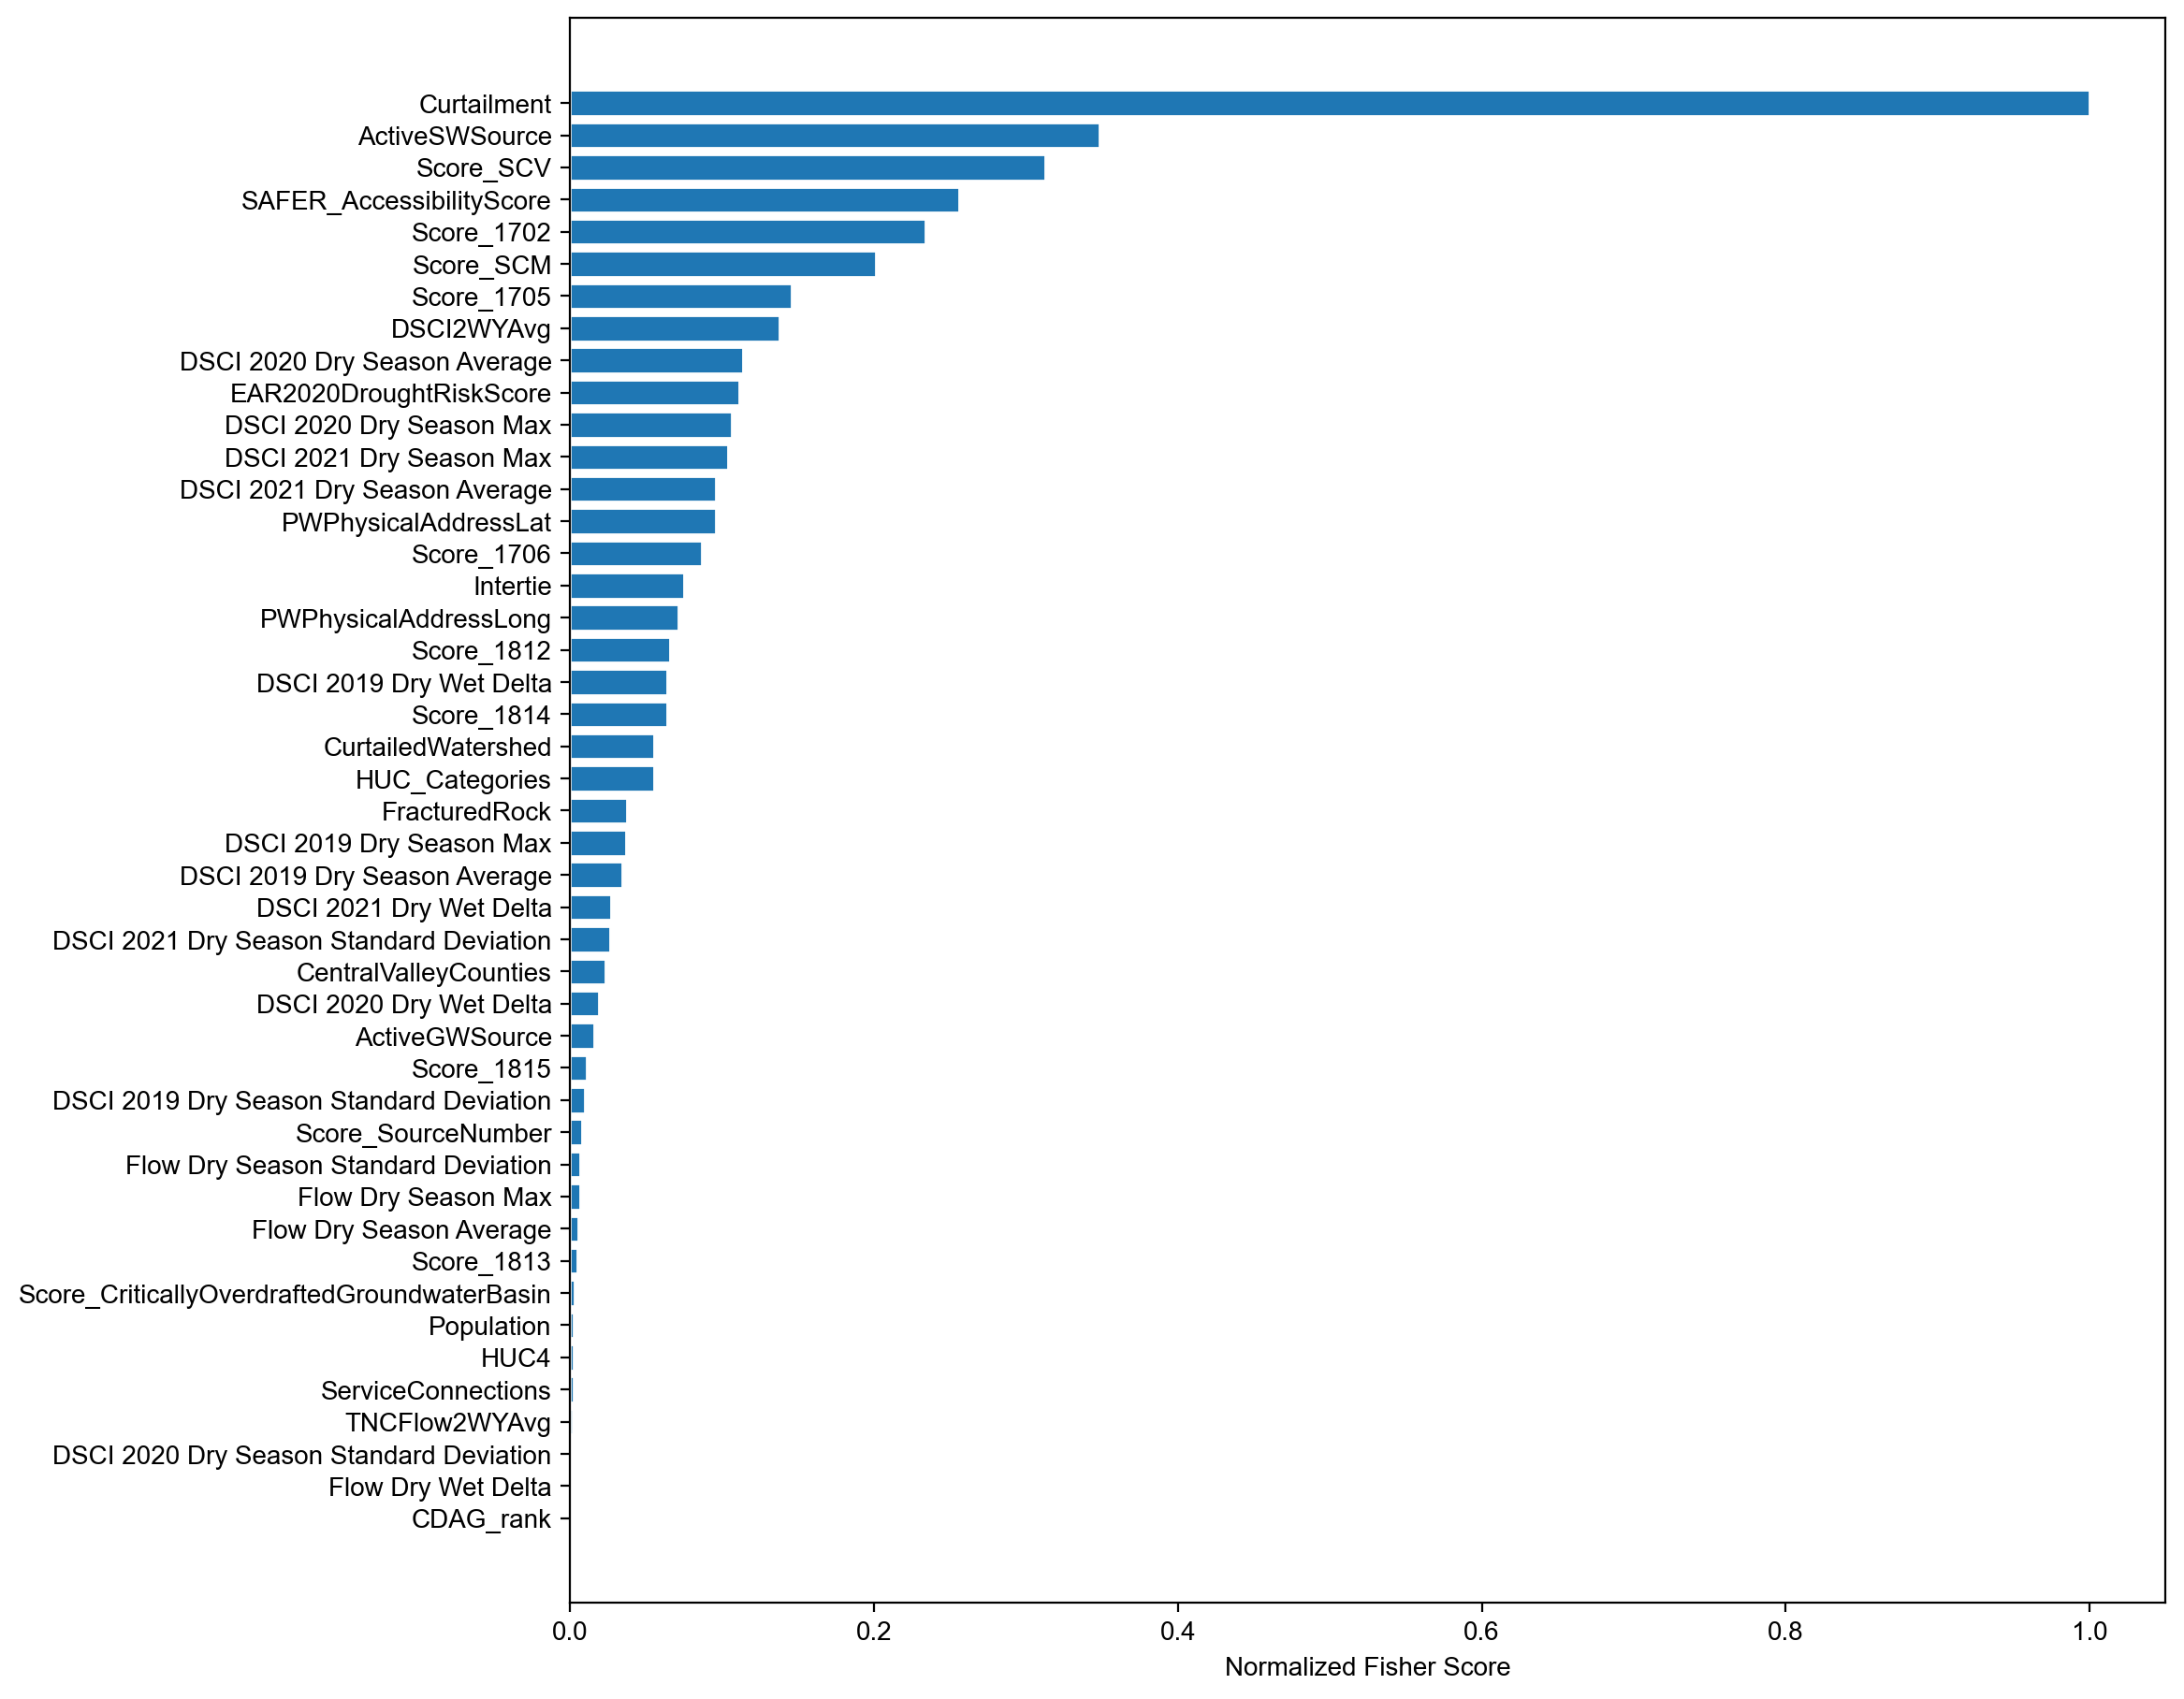

In [36]:
fig, ax = plt.subplots(figsize=(11,11))
sns.set_theme(style='whitegrid')

selector=SelectKBest(f_classif)
collist = df.columns.tolist()
selector.fit(df[collist[1:]],df['DroughtExperienced'])
scores = selector.scores_
scores[np.isnan(scores)] = 0.0

features = df[collist[1:]].columns.to_list()
order = np.argsort(scores)
ordered_features = [features[i] for i in order]
number_of_y_positions = np.arange(len(features))

ax.barh(number_of_y_positions, sorted(scores/np.nanmax(scores)))
ax.set_yticks(number_of_y_positions, ordered_features)
ax.set(xlabel = 'Normalized Fisher Score')
#fig.savefig('features.png', dpi=300, transparent=True, bbox_inches='tight')

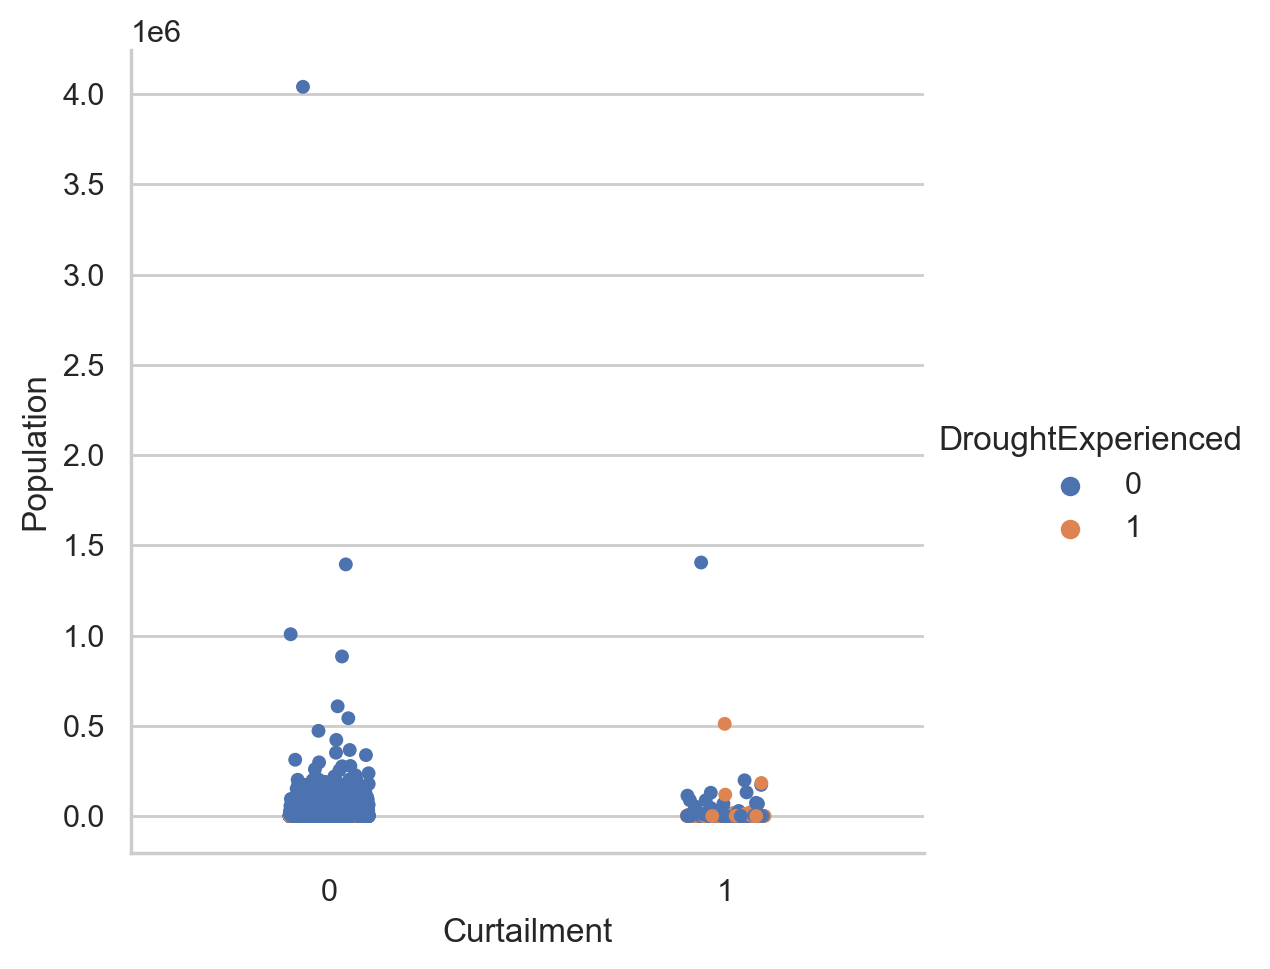

In [37]:
sns.set_theme(style='whitegrid')
fig = sns.catplot(data=df, x="Curtailment", y="Population", hue="DroughtExperienced")
#fig.savefig('curtailmentvpopulation.png', dpi=300, transparent=True, bbox_inches='tight')

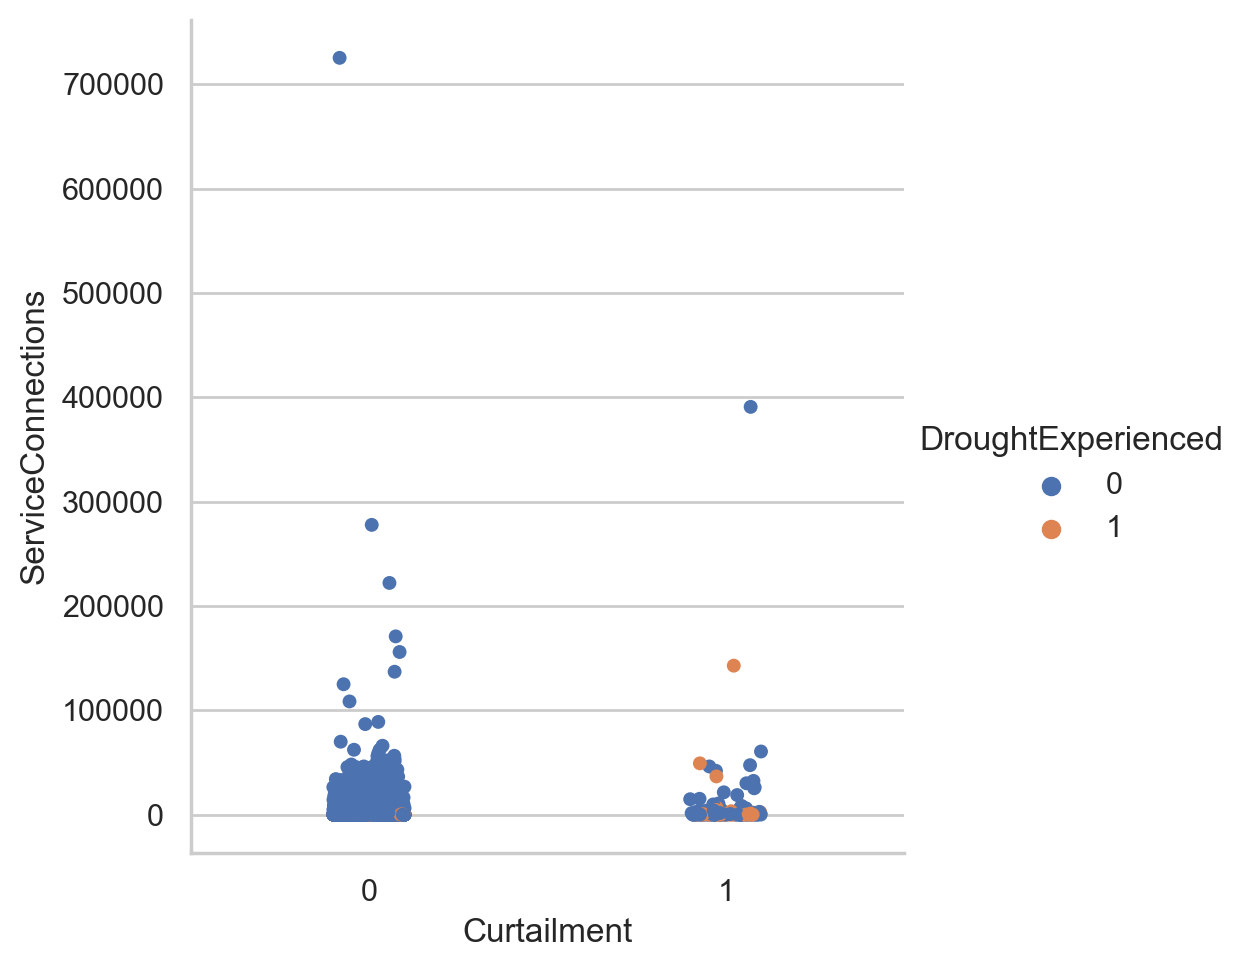

In [38]:
fig = sns.catplot(data=df, x="Curtailment", y="ServiceConnections", hue="DroughtExperienced")
#fig.savefig('curtailmentvserviceconnections.png', dpi=300, transparent=True, bbox_inches='tight')

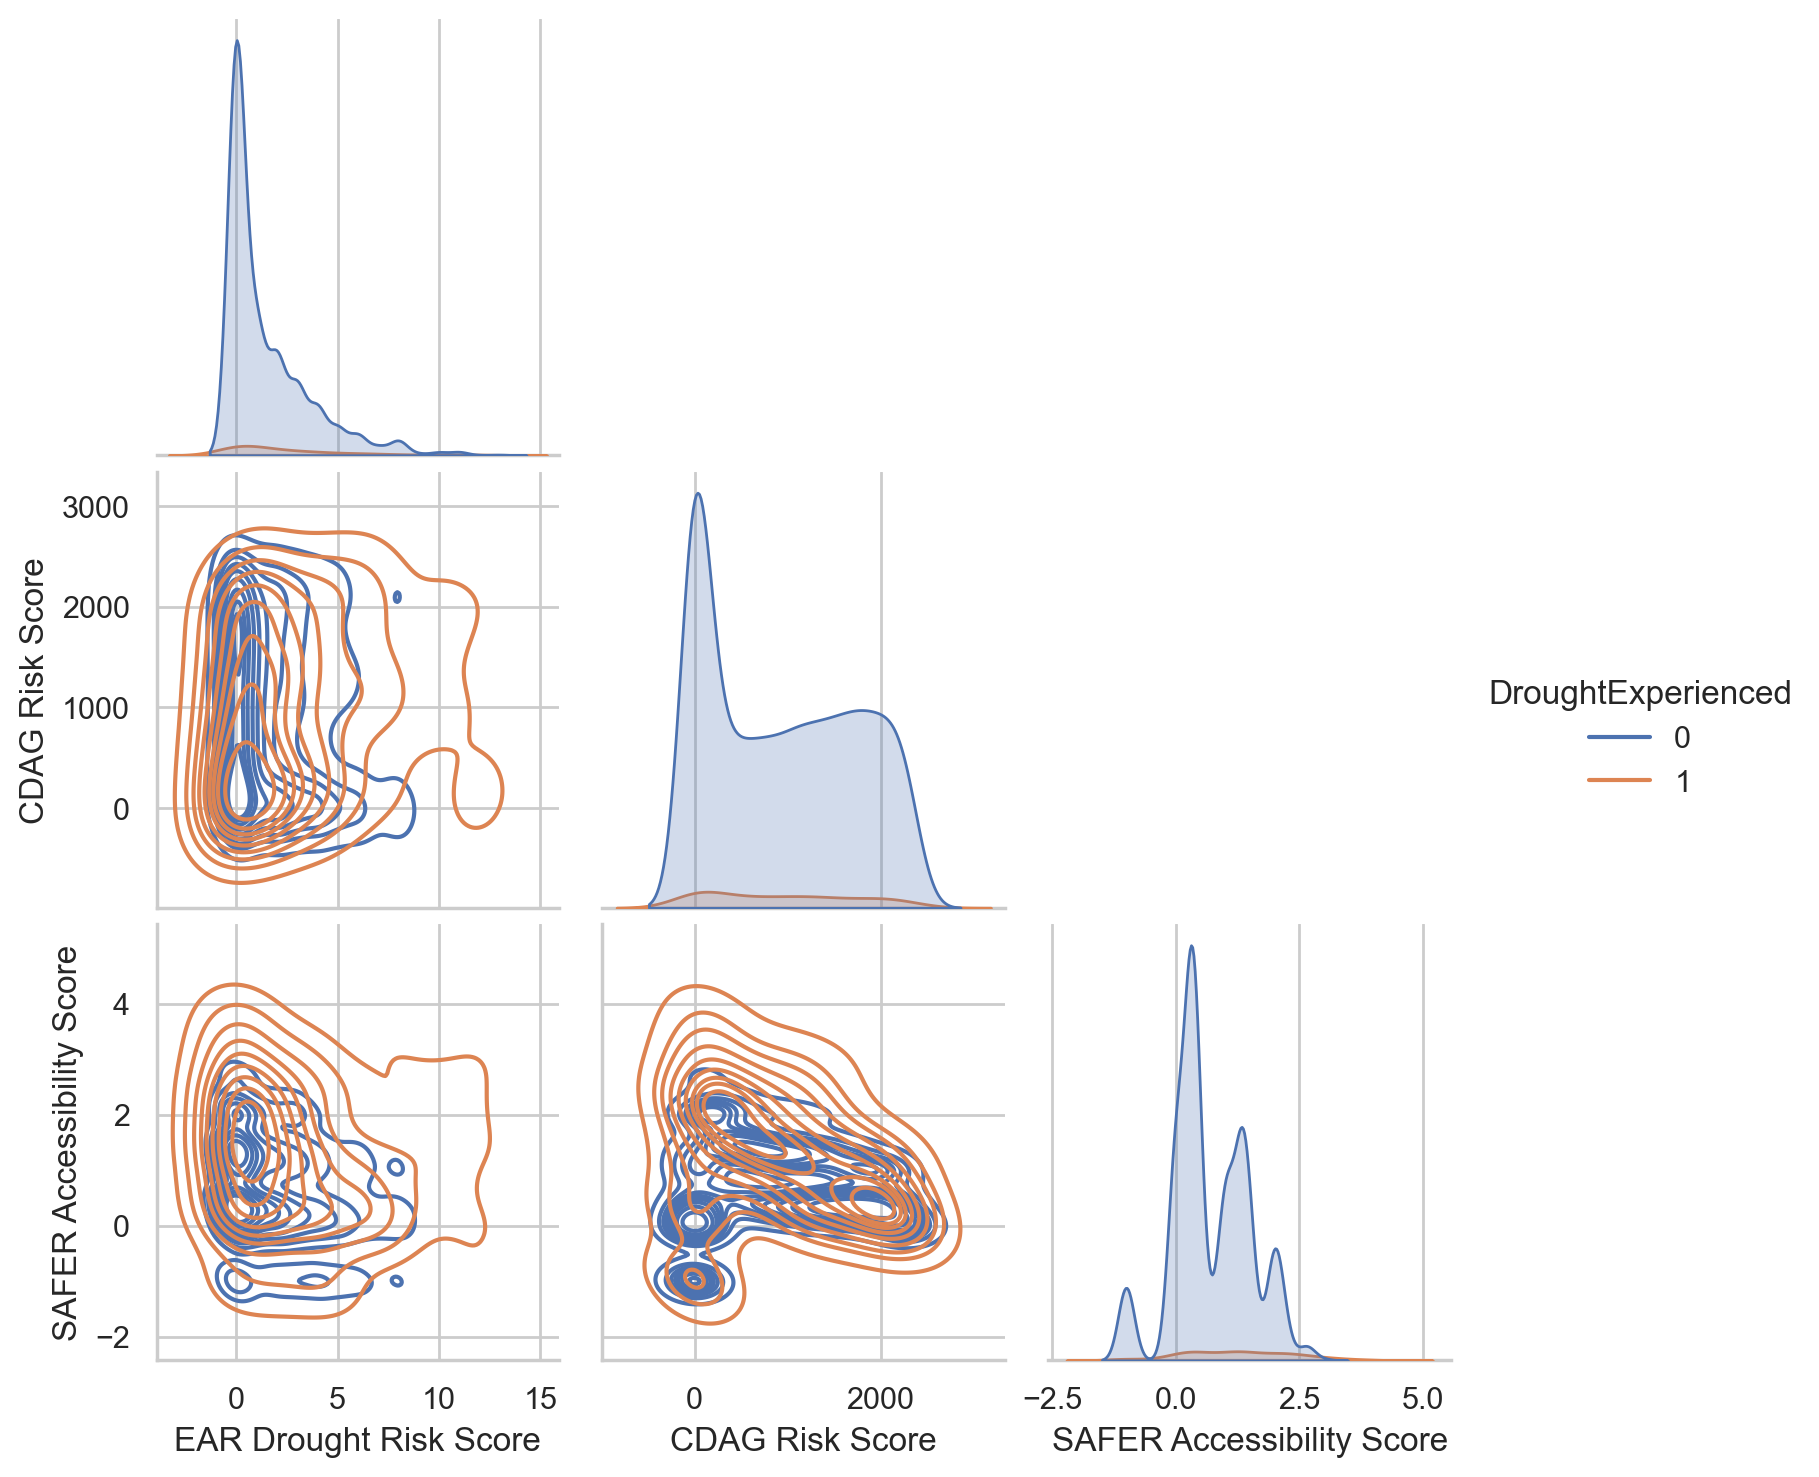

In [39]:
testdf = df[['DroughtExperienced', 'EAR2020DroughtRiskScore', 'CDAG_rank', 'SAFER_AccessibilityScore']]
testdf = testdf.rename(columns={'EAR2020DroughtRiskScore':'EAR Drought Risk Score', 'CDAG_rank': 'CDAG Risk Score', 'SAFER_AccessibilityScore': 'SAFER Accessibility Score'})
sns.pairplot(testdf, kind='kde', hue='DroughtExperienced', corner=True, plot_kws=dict(common_norm=False))#.savefig('kde.png', dpi=300, transparent=True, bbox_inches='tight')

### Split the data

Split the data into a training and a validation set.

In [40]:
y = df['DroughtExperienced']

In [41]:
X = df.drop(columns = 'DroughtExperienced')

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=7, shuffle=True)

In [43]:
print(f"The training set is {len(X_train)/len(X)*100}% of the data.")
print(f"The validation set is {len(X_val)/len(X)*100}% of the data.")

The training set is 69.9930216329379% of the data.
The validation set is 30.00697836706211% of the data.


### Scale the data

Scale the numeric features assuming the data obey a Gaussian distribution (is this is a reasonably fair assumption?). Leave the categorical features unscaled.

In [44]:
numeric_features = ['ServiceConnections', 'Population', 'CDAG_rank',
                    'SAFER_AccessibilityScore', 'PWPhysicalAddressLat',
                    'PWPhysicalAddressLong','ActiveGWSource', 'ActiveSWSource',
                    'DSCI2WYAvg', 'TNCFlow2WYAvg', 'Flow Dry Season Max', 
                    'Flow Dry Season Average', 'Flow Dry Season Standard Deviation', 'Flow Dry Wet Delta', 
                    'DSCI 2021 Dry Season Max', 'DSCI 2021 Dry Season Average',
                    'DSCI 2021 Dry Season Standard Deviation', 'DSCI 2021 Dry Wet Delta',
                    'DSCI 2020 Dry Season Max', 'DSCI 2020 Dry Season Average',
                    'DSCI 2020 Dry Season Standard Deviation', 'DSCI 2020 Dry Wet Delta',
                    'DSCI 2019 Dry Season Max', 'DSCI 2019 Dry Season Average',
                    'DSCI 2019 Dry Season Standard Deviation', 'DSCI 2019 Dry Wet Delta']
                    
categorical_features = ['Score_SourceNumber', 'Score_SCV',
       'Score_SCM', 'Score_CriticallyOverdraftedGroundwaterBasin', 
       'Curtailment', 'Score_1702', 'Score_1705', 'Score_1706', 'Score_1812',
       'Score_1813', 'Score_1814', 'Score_1815', 'EAR2020DroughtRiskScore',
       'CurtailedWatershed', 'HUC4', 'FracturedRock', 'Intertie',
       'CentralValleyCounties', 'HUC_Categories']

all_features = numeric_features + categorical_features

In [45]:
if (len(numeric_features) + len(categorical_features)) == len(X.columns):
    print('All variables are included.')

All variables are included.


Select and scale the numeric features.

In [46]:
scaler = preprocessing.StandardScaler()

In [47]:
X_train_numeric = X_train[numeric_features]
X_val_numeric = X_val[numeric_features]

Scale the validation set using the same mean and variance as the training set.

In [48]:
X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform()
X_val_numeric_scaled = scaler.transform(X_val_numeric)         # Use transform()

Append the unscaled categorical features.

In [49]:
X_train_categorical = np.array(X_train[categorical_features])
X_val_categorical = np.array(X_val[categorical_features])

In [50]:
X_train = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)
X_val = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)

In [51]:
X_train.shape, X_val.shape

((2006, 45), (860, 45))

### Train the model

* Using a RandomForestClassifier and same parameter values for now to mimic the original DDW model

In [52]:
clf = RandomForestClassifier(max_features=29, n_estimators=770, n_jobs=-1, random_state=42)

In [53]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_features=29, n_estimators=770, n_jobs=-1,
                       random_state=42)

In [54]:
y_pred = clf.predict(X_val)

### Question 1: Are the most predictive features static over time?

* In the previous model, the most predictive features were static over time.
* After some feature engineering, our model shows that the most predictive features vary with time.

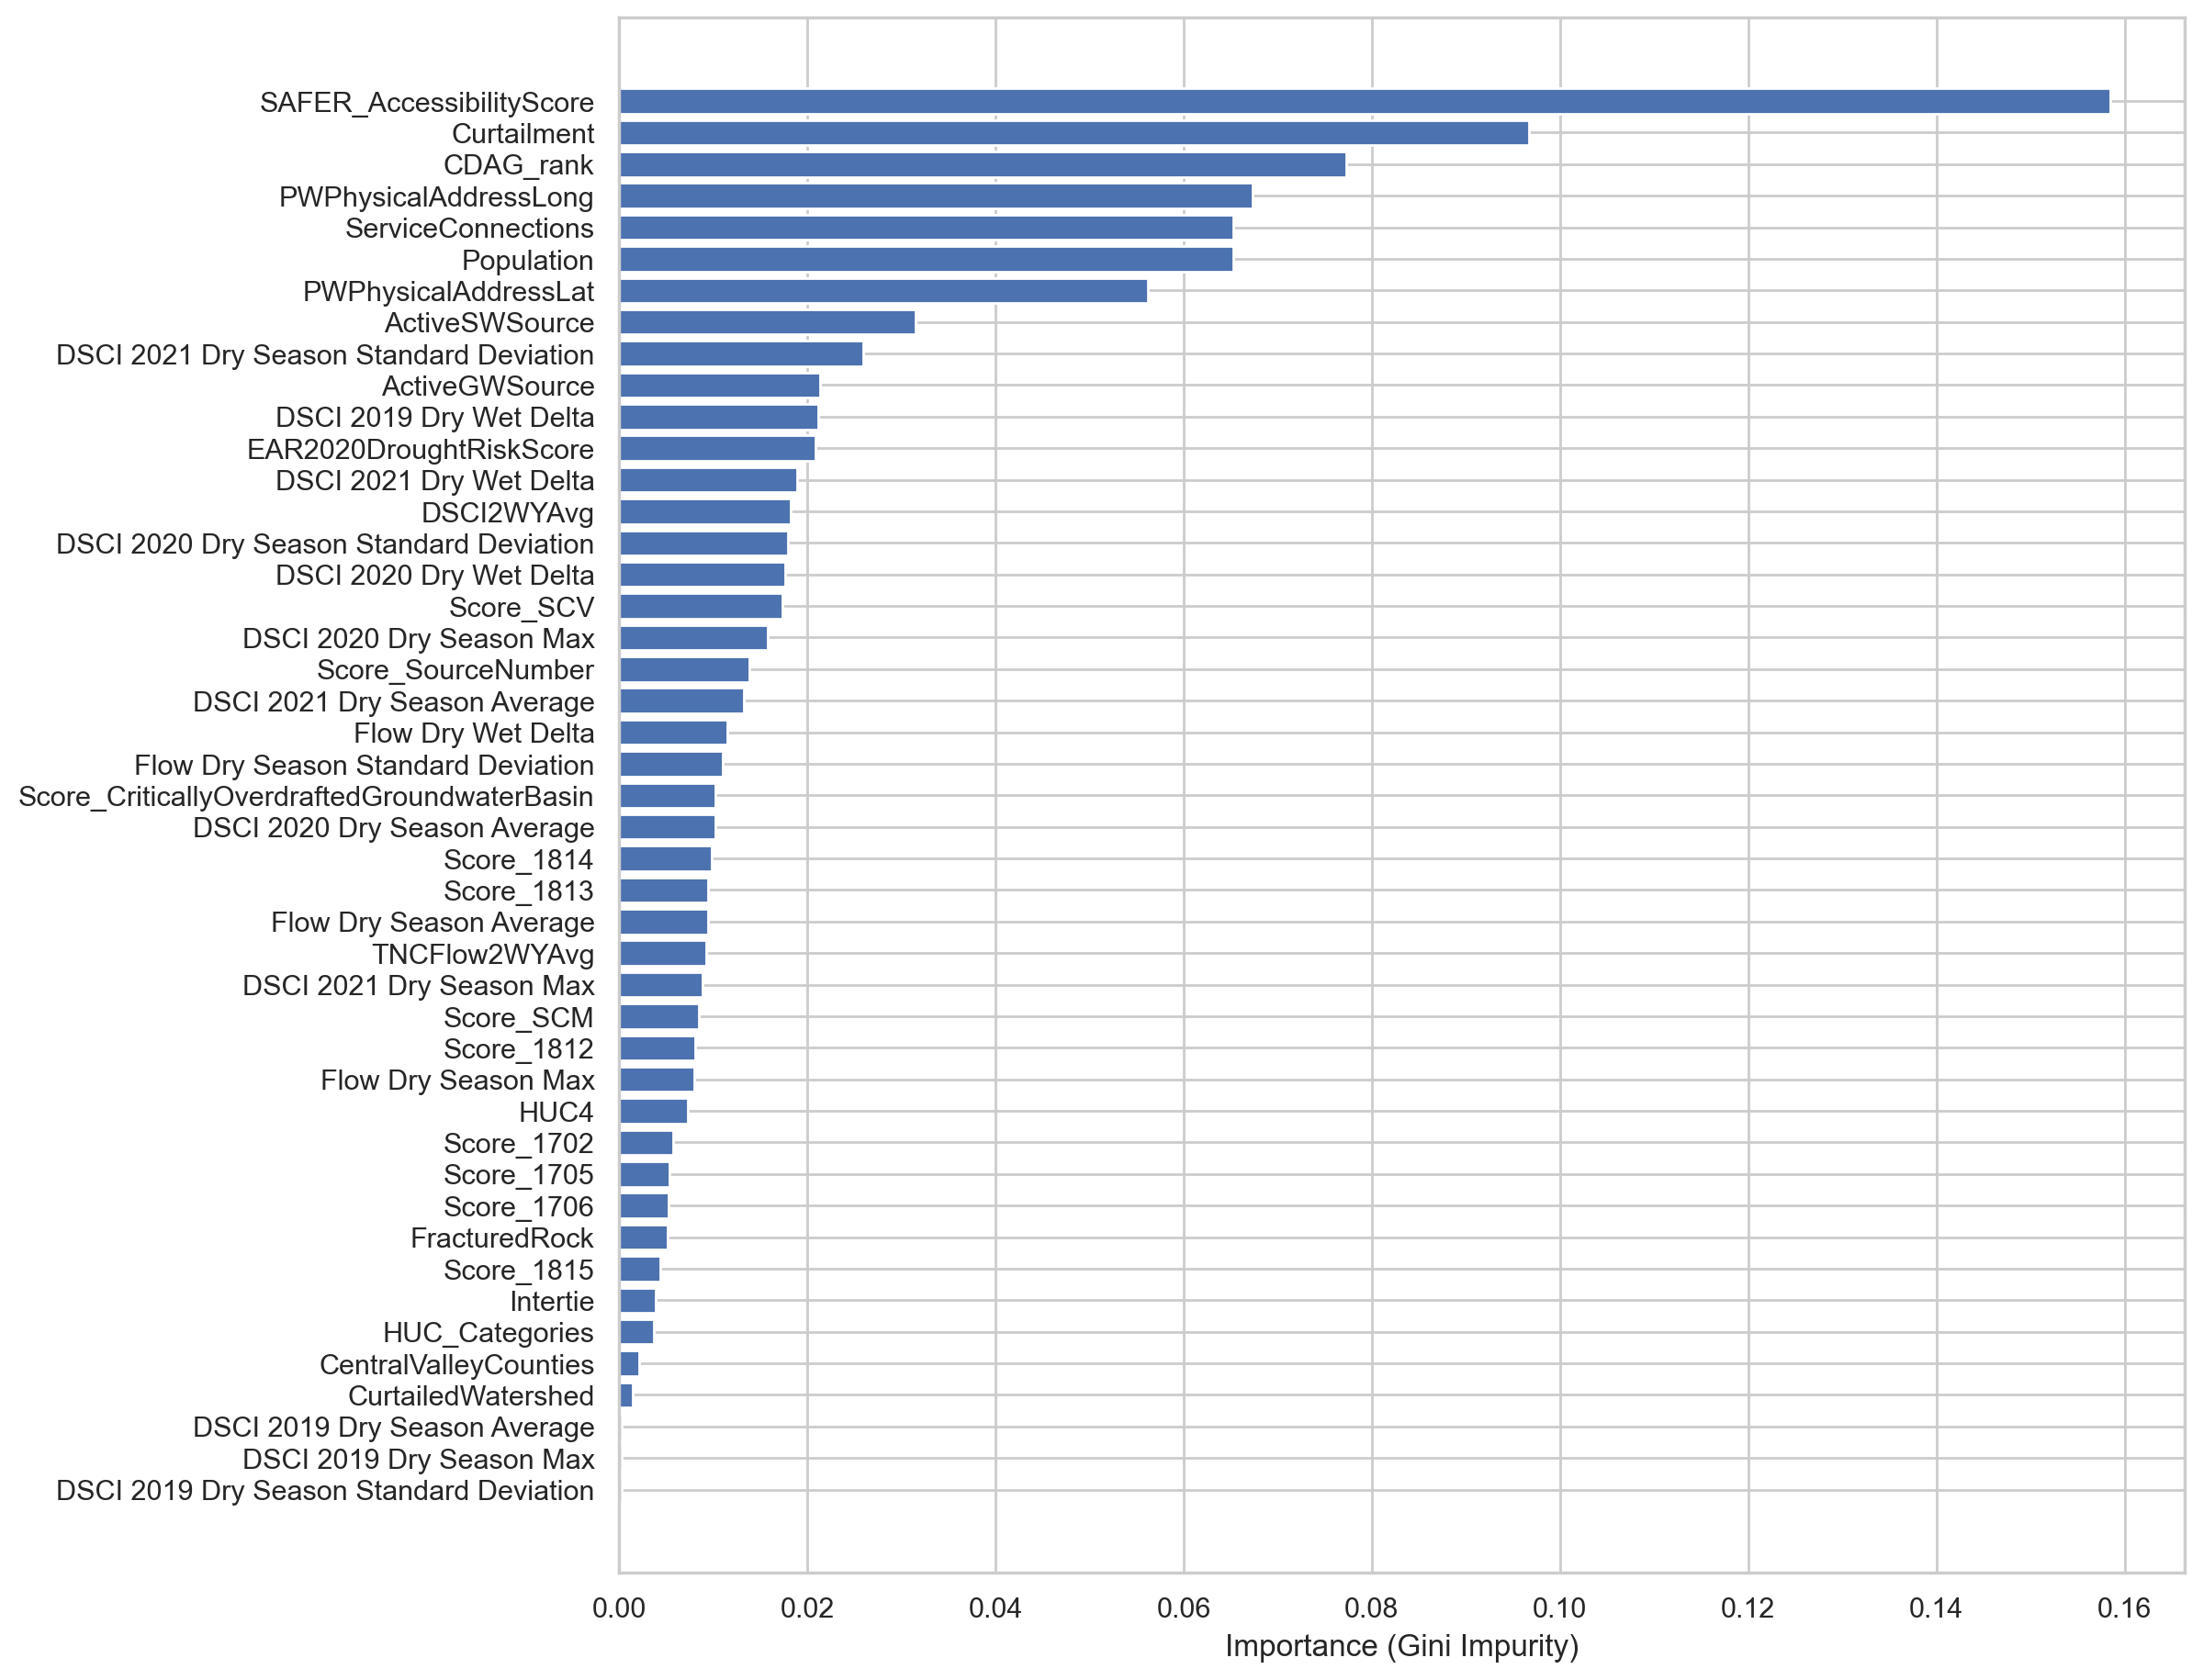

In [55]:
fig, ax = plt.subplots(figsize=(11,11))
sns.set_theme(style='whitegrid')

features = all_features
scores = clf.feature_importances_

order = np.argsort(scores)
ordered_features = [features[i] for i in order]
ordered_scores = sorted(scores)

ax.barh(ordered_features, ordered_scores)
ax.set(xlabel = 'Importance (Gini Impurity)')
fig.savefig('Gini_3.png', dpi=300, transparent=True, bbox_inches='tight')

Compare this to the features and scores in the previous model from the DDW ([see this Google sheet](https://docs.google.com/spreadsheets/d/17ZfqKys9XS0KR57rUTjGyJjk16dcf8GelyIgt_MYjVY/edit#gid=0)):

### Question 2: Does the model perform well? Yes.

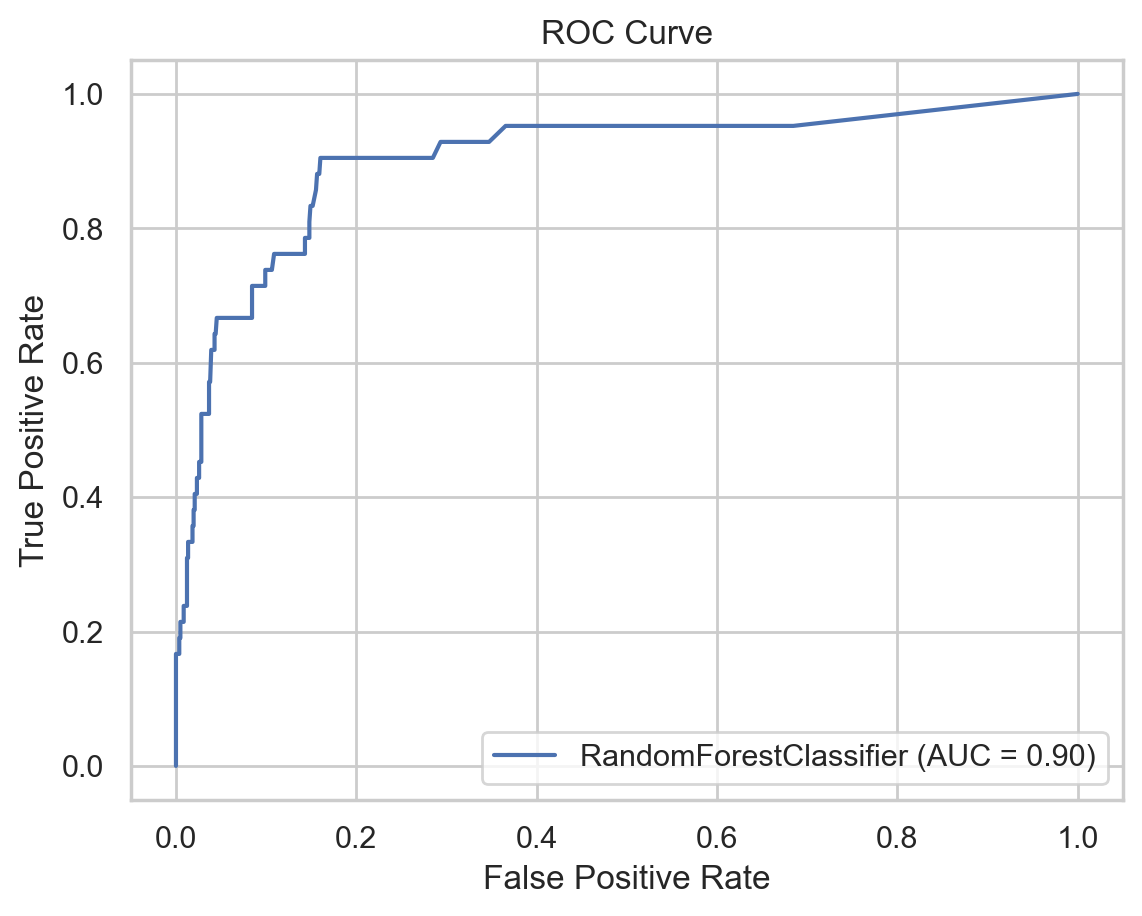

In [56]:
fig, ax = plt.subplots()
rfc_disp = metrics.RocCurveDisplay.from_estimator(clf, X_val, y_val, ax=ax, response_method='predict_proba')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
plt.show()

In [57]:
rfc_disp.roc_auc

0.9021277215042496

### Question 3: What does one of the 770 trees look like?

In [58]:
one_tree = clf.estimators_[50]

In [59]:
viz_model = dtreeviz.model(one_tree, X_train=X_train, y_train=y_train, feature_names=all_features,
                           target_name='DroughtExperienced', class_names=[0, 1])

In [60]:
out = viz_model.view(scale=0.8, orientation="LR")

In [61]:
out.save("tree50_2.svg")

### Question 4: Do more features improve model performance?

In [62]:
auc_values = []
auc_std = []
for i in range(len(ordered_features)):
    # Select the data
    y = df['DroughtExperienced']
    X = df[ordered_features[i:]]
    total_features = X.columns.to_list()
    
    auc_scores = []
    for j in range(10):
        # Split the data
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True)

        # Identify the numeric and categorical features
        total_numeric_features = list(set(total_features).intersection(numeric_features))
        total_categorical_features = list(set(total_features).intersection(categorical_features))

        # Select and scale the numeric features
        if total_numeric_features:
            scaler = preprocessing.StandardScaler()
            X_train_numeric = X_train[total_numeric_features]
            X_val_numeric = X_val[total_numeric_features]
            X_train_numeric_scaled = scaler.fit_transform(X_train_numeric) # Use fit_transform()
            X_val_numeric_scaled = scaler.transform(X_val_numeric)         # Use transform()

        # Select the categorical features
        if total_categorical_features:
            X_train_categorical = np.array(X_train[total_categorical_features])
            X_val_categorical = np.array(X_val[total_categorical_features])

        # Create training and validation sets
        if total_numeric_features and total_categorical_features:
            X_train = np.concatenate((X_train_numeric_scaled, X_train_categorical), axis=1)
            X_val = np.concatenate((X_val_numeric_scaled, X_val_categorical), axis=1)
        if total_numeric_features and not total_categorical_features:
            X_train = X_train_numeric_scaled
            X_val = X_val_numeric_scaled
        if not total_numeric_features and total_categorical_features:
            X_train = X_train_categorical
            X_val = X_val_categorical

        # Train the model
        clf = RandomForestClassifier(max_features=29, n_estimators=770, n_jobs=-1, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)

        # Calculate the AUC
        rfc_disp = metrics.RocCurveDisplay.from_estimator(clf, X_val, y_val, ax=ax, response_method='predict_proba');
        auc_scores.append(rfc_disp.roc_auc)
        
    auc_std.append(np.std(auc_scores))
    auc_values.append(np.mean(auc_scores))
    print(i,np.mean(auc_scores), np.std(auc_scores))

0 0.8927416512023265 0.015629795999919698
1 0.9018854391083849 0.026870191993225875
2 0.9092185973521504 0.009357869847332584
3 0.8804762232807863 0.023667200514137385
4 0.9002952534308688 0.009068611892247346
5 0.9056445745288594 0.01799399582574736
6 0.9041610567259196 0.015713933026454602
7 0.8948100208445571 0.01505975115658226
8 0.8993198097284767 0.013525508172725355
9 0.9005378736495622 0.023093830999641324
10 0.9069349796055499 0.01726484090418641
11 0.8973020954568316 0.015024782615855166
12 0.8963043268815941 0.01765671286410085
13 0.8908193668515455 0.025148350527119764
14 0.9023041775799268 0.016020494068035632
15 0.9101491037763043 0.018704155829652756
16 0.8877869627675855 0.014648461988955322
17 0.8988240567896556 0.02418107910152683
18 0.8890810874764485 0.017054168432569405
19 0.9052763753725444 0.016696628117092074
20 0.8924943750479576 0.017817933816815932
21 0.8865948249323493 0.01734558959918573
22 0.9020615784924167 0.026138684683201824
23 0.893565799794646 0.0196

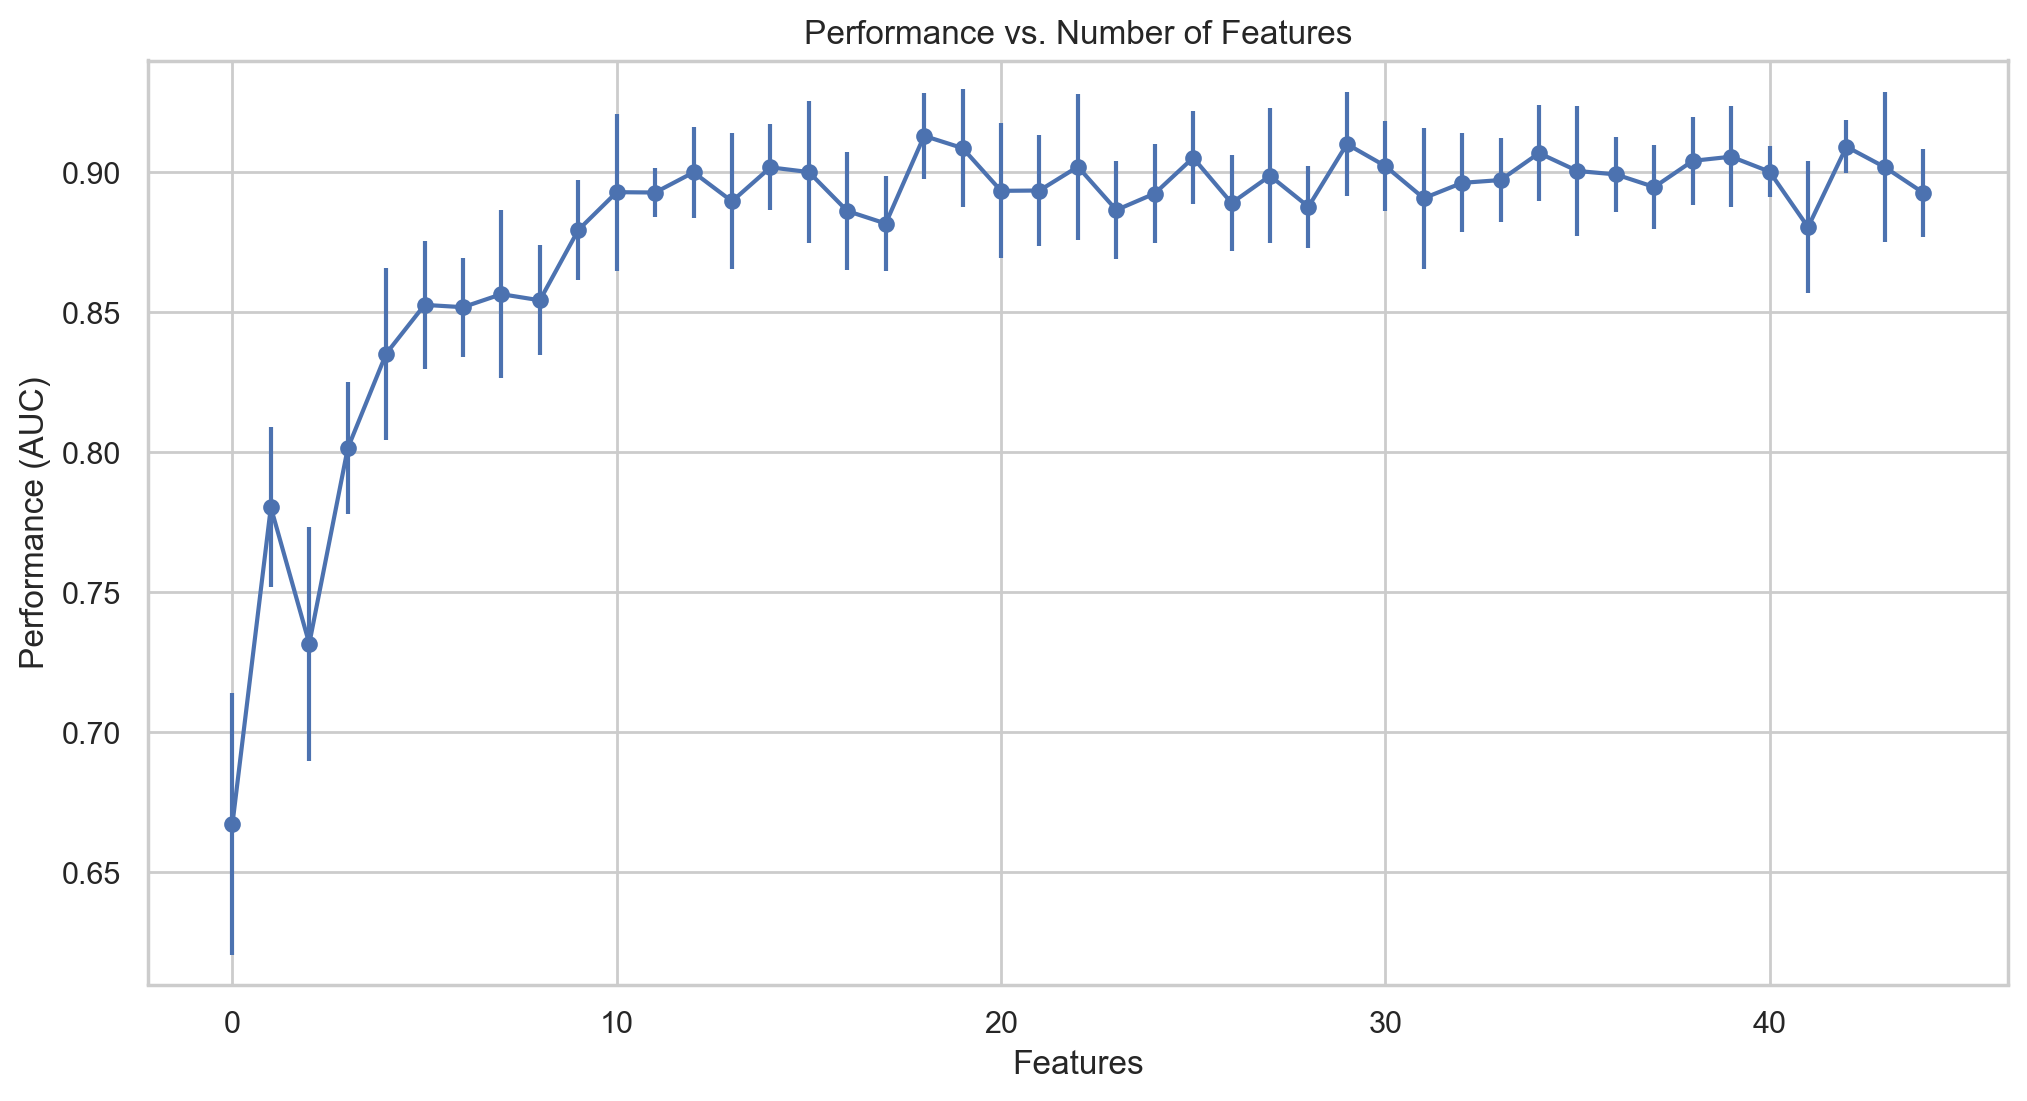

In [63]:
fig, ax = plt.subplots(figsize=(12,6))
sns.set_theme(style='whitegrid')
ax.errorbar(np.arange(45),np.flip(auc_values), yerr=np.flip(auc_std), marker=".", markersize=10)
ax.set_xlabel('Features')
ax.set_ylabel('Performance (AUC)')
ax.set_title('Performance vs. Number of Features')
ax.set_ylim([0.61, 0.94])
fig.savefig('performancevsfeatures_3.png', dpi=300, transparent=True, bbox_inches='tight')